In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install deap

In [3]:
!pip install bitstring

In [4]:
!pip install transforms3d

In [5]:
!pip install tsaug

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [7]:
pwd

'/content'

In [8]:
%cd "/content/drive/My Drive/Colab Notebooks/covid-dataset/"

/content/drive/My Drive/Colab Notebooks/covid-dataset


In [9]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [10]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/covid-dataset/owid-covid-data.csv') # having First.csv zipped file.

In [11]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [12]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [13]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [14]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [15]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [16]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [17]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [18]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [19]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [20]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [21]:
df = df.fillna(df.median())

In [22]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [23]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [24]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [25]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [26]:
#df['month'] = df['date'].dt.month

In [27]:
nb_seq=1
n_out=7
nb_col=5

In [28]:
start_date = '2020-03-02'
end_date = '2020-05-24'
start_date2 = '2020-05-25'
end_date2 = '2020-06-14'

In [29]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [30]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [31]:
df.sort_values(by=['location'], inplace=True)


In [32]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(84, 7)

In [33]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco


In [34]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23007,71.0,7023.0,193.0,1.0,36910558.0,2020-05-20,Morocco
23008,110.0,7133.0,194.0,1.0,36910558.0,2020-05-21,Morocco
23009,78.0,7211.0,196.0,2.0,36910558.0,2020-05-22,Morocco
23010,121.0,7332.0,197.0,1.0,36910558.0,2020-05-23,Morocco
23011,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco


In [35]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [36]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [37]:
X_train.shape

(84, 7)

In [38]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco
22933,7.0,615.0,10.0,0.0,36910558.0,2020-03-07,Morocco
22934,7.0,615.0,10.0,0.0,36910558.0,2020-03-08,Morocco
22935,7.0,615.0,10.0,0.0,36910558.0,2020-03-09,Morocco
22936,7.0,615.0,10.0,0.0,36910558.0,2020-03-10,Morocco
22937,7.0,615.0,10.0,0.0,36910558.0,2020-03-11,Morocco


In [39]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23002,95.0,6607.0,190.0,2.0,36910558.0,2020-05-15,Morocco
23003,45.0,6652.0,190.0,0.0,36910558.0,2020-05-16,Morocco
23004,89.0,6741.0,192.0,2.0,36910558.0,2020-05-17,Morocco
23005,129.0,6870.0,192.0,0.0,36910558.0,2020-05-18,Morocco
23006,82.0,6952.0,192.0,0.0,36910558.0,2020-05-19,Morocco
23007,71.0,7023.0,193.0,1.0,36910558.0,2020-05-20,Morocco
23008,110.0,7133.0,194.0,1.0,36910558.0,2020-05-21,Morocco
23009,78.0,7211.0,196.0,2.0,36910558.0,2020-05-22,Morocco
23010,121.0,7332.0,197.0,1.0,36910558.0,2020-05-23,Morocco
23011,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco


In [40]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(21, 7)

In [41]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [42]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco
1,27.0,7433.0,199.0,1.0,36910558.0,2020-05-25,Morocco
2,99.0,7532.0,200.0,1.0,36910558.0,2020-05-26,Morocco
3,45.0,7577.0,202.0,2.0,36910558.0,2020-05-27,Morocco
4,24.0,7601.0,202.0,0.0,36910558.0,2020-05-28,Morocco
5,42.0,7643.0,202.0,0.0,36910558.0,2020-05-29,Morocco
6,71.0,7714.0,202.0,0.0,36910558.0,2020-05-30,Morocco
7,66.0,7780.0,204.0,2.0,36910558.0,2020-05-31,Morocco
8,27.0,7807.0,205.0,1.0,36910558.0,2020-06-01,Morocco
9,26.0,7833.0,205.0,0.0,36910558.0,2020-06-02,Morocco


In [43]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [44]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [45]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [46]:
#days=days[nb_seq:]

In [47]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(84, 5)
(84, 1)
(22, 5)
(22, 1)


In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [49]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [50]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


    var1(t-1)  var2(t-1)  var3(t-1)  ...  var3(t+6)  var4(t+6)  var5(t+6)
1    0.024911   0.082917   0.050505  ...   0.050505   0.000000        0.0
2    0.003559   0.000000   0.000000  ...   0.050505   0.000000        0.0
3    0.024911   0.082917   0.050505  ...   0.050505   0.000000        0.0
4    0.024911   0.082917   0.050505  ...   0.005051   0.066667        0.0
5    0.003559   0.000135   0.000000  ...   0.005051   0.000000        0.0
..        ...        ...        ...  ...        ...        ...        ...
73   0.487544   0.866577   0.949495  ...   0.974747   0.066667        0.0
74   0.334520   0.879271   0.949495  ...   0.979798   0.066667        0.0
75   0.338078   0.892100   0.959596  ...   0.989899   0.133333        0.0
76   0.160142   0.898177   0.959596  ...   0.994950   0.066667        0.0
77   0.316726   0.910196   0.969697  ...   1.000000   0.066667        0.0

[77 rows x 40 columns]
(77, 40)
(15, 40)
(77, 8)
(15, 8)


In [51]:
print(X_test)

    var1(t-1)  var2(t-1)  var3(t-1)  ...  var3(t+6)  var4(t+6)  var5(t+6)
1    0.478633   0.000000   0.000000  ...   0.428572        1.0        0.0
2    0.076923   0.020995   0.071429  ...   0.500000        0.5        0.0
3    0.692308   0.097978   0.142858  ...   0.500000        0.0        0.0
4    0.230769   0.132970   0.285714  ...   0.571429        0.5        0.0
5    0.051282   0.151633   0.285714  ...   0.571429        0.0        0.0
6    0.205128   0.184292   0.285714  ...   0.714286        1.0        0.0
7    0.452991   0.239502   0.285714  ...   0.714286        0.0        0.0
8    0.410256   0.290824   0.428572  ...   0.714286        0.0        0.0
9    0.076923   0.311820   0.500000  ...   0.714286        0.0        0.0
10   0.068376   0.332037   0.500000  ...   0.714286        0.0        0.0
11   0.128205   0.357698   0.571429  ...   0.857143        1.0        0.0
12   0.324786   0.401244   0.571429  ...   0.857143        0.0        0.0
13   0.538462   0.464230   0.714286  .

In [52]:
#col_y_need_train = df.filter(regex=("d.*"))

In [53]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2),var1(t+3),var2(t+3),var3(t+3),var4(t+3),var5(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
1,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000000,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
2,0.003559,0.000000,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
3,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
4,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0
5,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0,0.003559,0.000675,0.005051,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.487544,0.866577,0.949495,0.000000,0.0,0.334520,0.879271,0.949495,0.000000,0.0,0.338078,0.892100,0.959596,0.133333,0.0,0.160142,0.898177,0.959596,0.000000,0.0,0.316726,0.910196,0.969697,0.133333,0.0,0.459075,0.927616,0.969697,0.000000,0.0,0.291815,0.938690,0.969697,0.000000,0.0,0.252669,0.948278,0.974747,0.066667,0.0
74,0.334520,0.879271,0.949495,0.000000,0.0,0.338078,0.892100,0.959596,0.133333,0.0,0.160142,0.898177,0.959596,0.000000,0.0,0.316726,0.910196,0.969697,0.133333,0.0,0.459075,0.927616,0.969697,0.000000,0.0,0.291815,0.938690,0.969697,0.000000,0.0,0.252669,0.948278,0.974747,0.066667,0.0,0.391459,0.963133,0.979798,0.066667,0.0
75,0.338078,0.892100,0.959596,0.133333,0.0,0.160142,0.898177,0.959596,0.000000,0.0,0.316726,0.910196,0.969697,0.133333,0.0,0.459075,0.927616,0.969697,0.000000,0.0,0.291815,0.938690,0.969697,0.000000,0.0,0.252669,0.948278,0.974747,0.066667,0.0,0.391459,0.963133,0.979798,0.066667,0.0,0.277580,0.973666,0.989899,0.133333,0.0
76,0.160142,0.898177,0.959596,0.000000,0.0,0.316726,0.910196,0.969697,0.133333,0.0,0.459075,0.927616,0.969697,0.000000,0.0,0.291815,0.938690,0.969697,0.000000,0.0,0.252669,0.948278,0.974747,0.066667,0.0,0.391459,0.963133,0.979798,0.066667,0.0,0.277580,0.973666,0.989899,0.133333,0.0,0.430605,0.990007,0.994950,0.066667,0.0


In [54]:
Y_train.head(5)

,var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
1,0.024911,0.003559,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911
2,0.003559,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911
3,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911
4,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676
5,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676,0.003559


In [55]:
#raise SystemExit("Stop right there!")

In [56]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [57]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [58]:
col_x_need_train

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.024911,0.082917,0.050505,0.0,0.0


In [59]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
1,0.003559,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911


In [60]:
#raise SystemExit("Stop right there!")

In [61]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [62]:
#col_x_need_train

In [63]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(77, 7)
(15, 7)


In [64]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
1,0.003559,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911
2,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911
3,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911
4,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676
5,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676,0.003559


In [65]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(77, 5)
(15, 5)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.024911,0.082917,0.050505,0.000000,0.0
2,0.003559,0.000000,0.000000,0.000000,0.0
3,0.024911,0.082917,0.050505,0.000000,0.0
4,0.024911,0.082917,0.050505,0.000000,0.0
5,0.003559,0.000135,0.000000,0.000000,0.0
...,...,...,...,...,...
73,0.487544,0.866577,0.949495,0.000000,0.0
74,0.334520,0.879271,0.949495,0.000000,0.0
75,0.338078,0.892100,0.959596,0.133333,0.0
76,0.160142,0.898177,0.959596,0.000000,0.0


In [66]:
X_test

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.478633,0.000000,0.000000,0.5,0.0
2,0.076923,0.020995,0.071429,0.5,0.0
3,0.692308,0.097978,0.142858,0.5,0.0
4,0.230769,0.132970,0.285714,1.0,0.0
5,0.051282,0.151633,0.285714,0.0,0.0
6,0.205128,0.184292,0.285714,0.0,0.0
7,0.452991,0.239502,0.285714,0.0,0.0
8,0.410256,0.290824,0.428572,1.0,0.0
9,0.076923,0.311820,0.500000,0.5,0.0
10,0.068376,0.332037,0.500000,0.0,0.0


In [67]:
print(X_test.shape)

(15, 5)


In [68]:
nb_col=5

In [69]:
X_test.head(1)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.478633,0.0,0.0,0.5,0.0


In [70]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(15, 1, 5) (15, 7) (77, 1, 5) (77, 7)


In [71]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(15, 1, 5) (15, 7) (77, 1, 5) (77, 7)


In [72]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [73]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [74]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [75]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:7])
    cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    print('\nUnits CNN1: ',cnn_units1,'Units CNN2: ',cnn_units2,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units2,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    model.add(Dropout(0.2))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=1000,batch_size=1, validation_data=(X_test[[0,7,14]], Y_test[[0,7,14]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7,14]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7,14]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,


Units CNN1:  125 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0930 - val_loss: 0.0583
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0580
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0576
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0597
Epoch 5/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0619
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0637
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0692
Epoch 8/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0610
Epoch 9/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0639
Epoch 10/1000
77/77 [==============

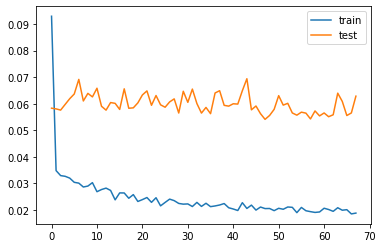

(77, 7)
(77, 7)
(77, 7)
score_train: [15.839] 16.0, 16.4, 16.1, 15.9, 15.8, 15.0, 15.6
(15, 1, 5)
score_test: [29.327] 20.9, 41.4, 45.7, 25.5, 21.3, 17.3, 19.4

RMSE test:  29.327482147940444 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0744 - val_loss: 0.0646
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0363 - val_loss: 0.0649
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0623
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0596
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0637
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0635
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0639
Epoch 8/1000
77/77 [=====================

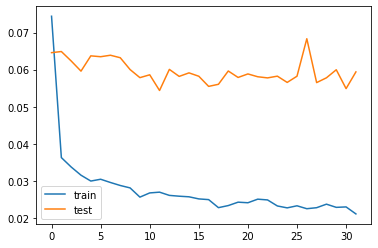

(77, 7)
(77, 7)
(77, 7)
score_train: [16.185] 15.7, 15.7, 16.5, 16.0, 16.6, 16.3, 16.4
(15, 1, 5)
score_test: [28.511] 16.7, 40.0, 42.5, 26.4, 19.6, 21.8, 21.1

RMSE test:  28.51148490781564 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0859 - val_loss: 0.0656
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0367 - val_loss: 0.0607
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0654
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0697
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0667
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0654
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0651
Epoch 8/1000
77/77 [======================

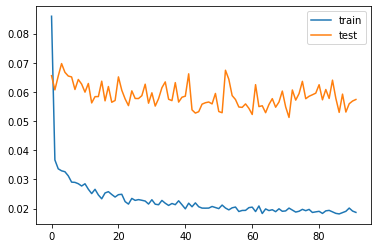

(77, 7)
(77, 7)
(77, 7)
score_train: [14.977] 14.4, 14.7, 15.2, 15.4, 15.4, 14.5, 15.1
(15, 1, 5)
score_test: [28.032] 18.3, 40.5, 41.9, 27.9, 20.9, 15.6, 17.5

RMSE test:  28.03236441814043 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0660
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0658
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0659
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0681
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0631
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0627
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0664
Epoch 8/1000
77/77 [======================

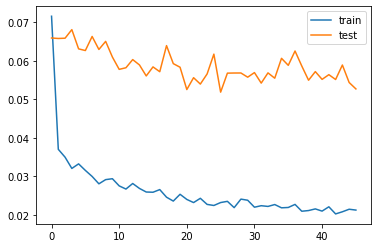

(77, 7)
(77, 7)
(77, 7)
score_train: [15.996] 15.2, 15.6, 16.1, 15.9, 16.5, 16.1, 16.5
(15, 1, 5)
score_test: [26.868] 18.4, 36.4, 42.2, 28.9, 13.2, 15.8, 18.7

RMSE test:  26.86808285287437 


Units CNN1:  127 Units CNN2:  126 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0690 - val_loss: 0.0624
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0655
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0651
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0644
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0637
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0612
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0637
Epoch 8/1000
77/77 [======================

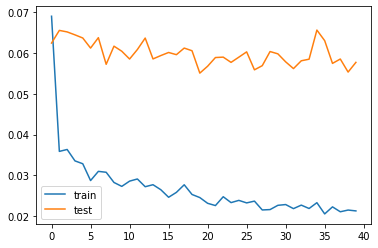

(77, 7)
(77, 7)
(77, 7)
score_train: [15.948] 15.6, 15.6, 16.0, 15.8, 16.4, 15.6, 16.5
(15, 1, 5)
score_test: [28.101] 19.8, 39.9, 43.4, 28.4, 16.6, 15.6, 18.3

RMSE test:  28.101444369692274 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0679 - val_loss: 0.0859
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0722
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0700
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0671
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0641
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0651
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0616
Epoch 8/1000
77/77 [=====================

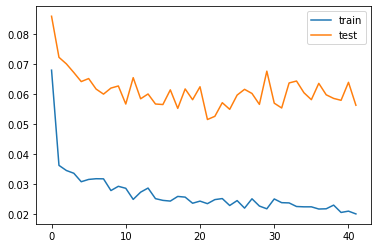

(77, 7)
(77, 7)
(77, 7)
score_train: [16.183] 15.6, 16.5, 16.9, 16.1, 16.3, 15.7, 16.2
(15, 1, 5)
score_test: [27.740] 20.7, 38.5, 40.0, 28.2, 16.2, 19.8, 20.7

RMSE test:  27.73978390698021 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.0642
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0602
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0604
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0584
Epoch 5/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0585
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0574
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0562
Epoch 8/1000
77/77 [======================

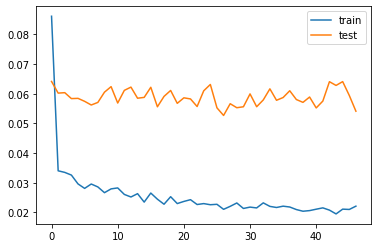

(77, 7)
(77, 7)
(77, 7)
score_train: [15.944] 15.3, 15.9, 16.0, 16.0, 16.3, 15.7, 16.4
(15, 1, 5)
score_test: [27.218] 19.7, 37.3, 41.1, 29.1, 18.2, 15.4, 17.4

RMSE test:  27.21816972764867 


Units CNN1:  63 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0932 - val_loss: 0.0624
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0421 - val_loss: 0.0609
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0400 - val_loss: 0.0628
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0634
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0637
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0615
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0605
Epoch 8/1000
77/77 [=======================

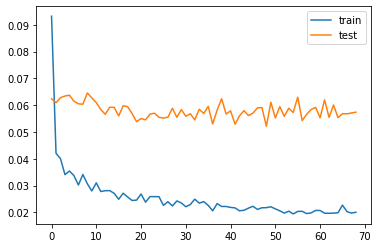

(77, 7)
(77, 7)
(77, 7)
score_train: [15.518] 15.5, 15.1, 15.7, 15.7, 15.9, 15.1, 15.7
(15, 1, 5)
score_test: [28.030] 18.5, 37.3, 43.4, 28.2, 22.7, 14.8, 18.8

RMSE test:  28.02983716464204 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0664
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.0660
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0614
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0669
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0702
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0634
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0630
Epoch 8/1000
77/77 [======================

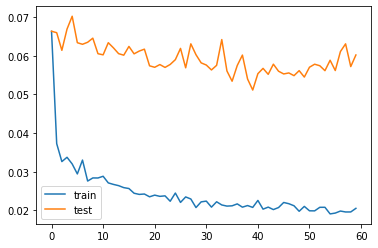

(77, 7)
(77, 7)
(77, 7)
score_train: [15.509] 15.5, 15.2, 15.7, 15.6, 15.7, 15.2, 15.8
(15, 1, 5)
score_test: [28.711] 18.5, 39.2, 43.1, 28.2, 21.1, 19.0, 20.7

RMSE test:  28.711252191730168 


Units CNN1:  127 Units CNN2:  121 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0651
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0606
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0594
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0639
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0638
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0672
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0598
Epoch 8/1000
77/77 [=====================

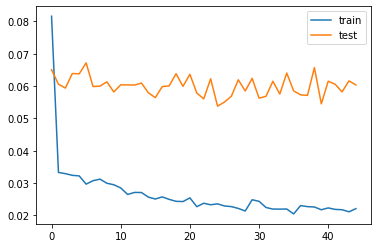

(77, 7)
(77, 7)
(77, 7)
score_train: [15.937] 15.5, 15.7, 16.1, 15.9, 16.4, 15.7, 16.2
(15, 1, 5)
score_test: [28.743] 16.2, 42.1, 42.8, 26.9, 21.0, 18.4, 20.3

RMSE test:  28.74254557096405 

gen	nevals	avg    	std     	min    	max    
0  	10    	27.3948	0.856198	26.8681	29.3275

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0876 - val_loss: 0.0593
Epoch 2/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0606
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0629
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0640
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0612
Epoch 6/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0634
Epoch 7/1000
77/77 [==============================] - 

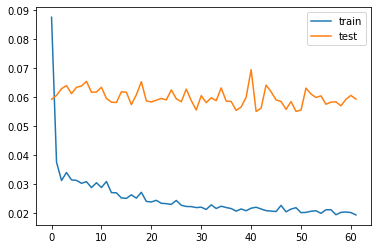

(77, 7)
(77, 7)
(77, 7)
score_train: [15.410] 15.0, 15.2, 15.8, 15.6, 15.7, 15.0, 15.6
(15, 1, 5)
score_test: [28.499] 20.0, 38.8, 45.7, 27.4, 16.8, 17.2, 18.8

RMSE test:  28.498900427310033 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0693 - val_loss: 0.0694
Epoch 2/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0662
Epoch 3/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0702
Epoch 4/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0673
Epoch 5/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0641
Epoch 6/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0636
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0628
Epoch 8/1000
77/77 [=====================

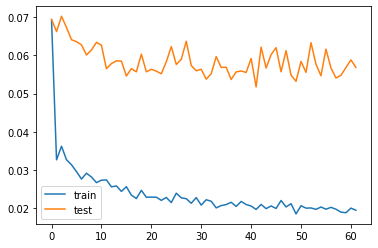

(77, 7)
(77, 7)
(77, 7)
score_train: [15.261] 15.0, 15.0, 15.4, 15.6, 15.7, 14.7, 15.4
(15, 1, 5)
score_test: [27.897] 20.4, 40.3, 43.5, 30.5, 17.9, 9.8, 13.2

RMSE test:  27.897264366004798 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0743 - val_loss: 0.0615
Epoch 2/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0614
Epoch 3/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0716
Epoch 4/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0636
Epoch 5/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0636
Epoch 6/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0615
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0654
Epoch 8/1000
77/77 [======================

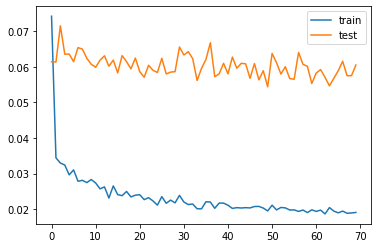

(77, 7)
(77, 7)
(77, 7)
score_train: [15.423] 14.7, 14.9, 15.7, 15.6, 16.1, 15.0, 15.9
(15, 1, 5)
score_test: [28.786] 19.4, 39.0, 43.3, 27.4, 22.2, 15.8, 23.0

RMSE test:  28.78638556574712 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0977 - val_loss: 0.0662
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0633
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0643
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0656
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0641
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0621
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0627
Epoch 8/1000
77/77 [======================

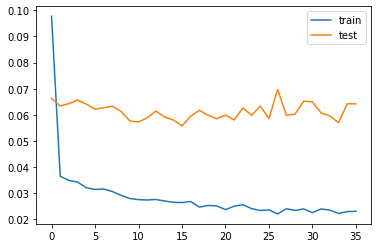

(77, 7)
(77, 7)
(77, 7)
score_train: [16.425] 15.7, 16.2, 16.6, 16.5, 17.0, 16.4, 16.6
(15, 1, 5)
score_test: [29.635] 19.9, 41.6, 44.8, 25.2, 21.2, 20.0, 22.9

RMSE test:  29.635243154834846 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 1s 7ms/step - loss: 0.0760 - val_loss: 0.0618
Epoch 2/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0572
Epoch 3/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0589
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0635
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0599
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0600
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0593
Epoch 8/1000
77/77 [=====================

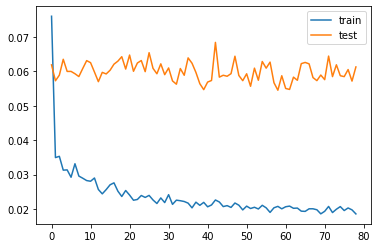

(77, 7)
(77, 7)
(77, 7)
score_train: [15.183] 14.8, 14.8, 15.5, 15.2, 15.6, 14.7, 15.6
(15, 1, 5)
score_test: [28.956] 19.5, 42.7, 43.5, 30.9, 17.0, 15.6, 16.7

RMSE test:  28.956309070830645 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0945 - val_loss: 0.0685
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0711
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0651
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0624
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0707
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0725
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0621
Epoch 8/1000
77/77 [=====================

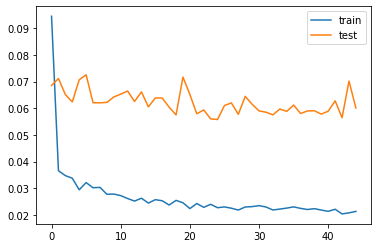

(77, 7)
(77, 7)
(77, 7)
score_train: [16.033] 16.4, 15.8, 16.3, 15.9, 16.4, 15.4, 16.0
(15, 1, 5)
score_test: [28.679] 21.8, 39.2, 42.4, 29.5, 15.4, 18.5, 22.4

RMSE test:  28.679495097040952 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0844 - val_loss: 0.0659
Epoch 2/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0669
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0675
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0678
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0660
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0643
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0692
Epoch 8/1000
77/77 [=====================

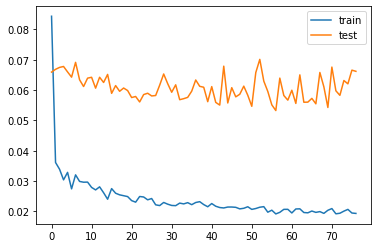

(77, 7)
(77, 7)
(77, 7)
score_train: [15.972] 15.9, 16.4, 16.3, 15.7, 16.1, 15.5, 15.8
(15, 1, 5)
score_test: [30.104] 21.3, 41.2, 48.1, 25.8, 22.7, 17.3, 19.8

RMSE test:  30.103980457703702 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.0663
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0626
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0658
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0640
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0576
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0585
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0619
Epoch 8/1000
77/77 [=====================

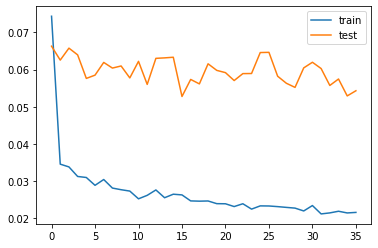

(77, 7)
(77, 7)
(77, 7)
score_train: [15.924] 15.5, 15.9, 16.0, 15.8, 16.6, 15.5, 16.1
(15, 1, 5)
score_test: [27.262] 20.5, 37.0, 42.0, 27.2, 14.2, 17.0, 20.6

RMSE test:  27.26201348300283 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0865 - val_loss: 0.0596
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0606
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0603
Epoch 4/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0600
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0675
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0601
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0611
Epoch 8/1000
77/77 [======================

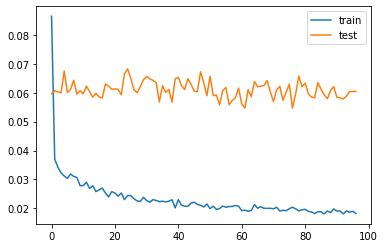

(77, 7)
(77, 7)
(77, 7)
score_train: [15.109] 14.7, 15.0, 15.4, 15.4, 15.6, 14.3, 15.3
(15, 1, 5)
score_test: [28.761] 18.7, 43.2, 43.8, 31.5, 19.9, 8.7, 13.9

RMSE test:  28.760703726833935 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0911 - val_loss: 0.0617
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0358 - val_loss: 0.0600
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0607
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0635
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0625
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0635
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0647
Epoch 8/1000
77/77 [======================

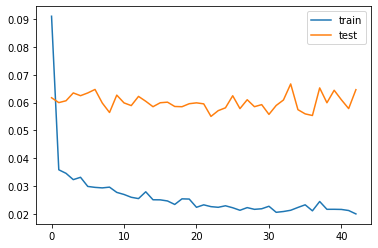

(77, 7)
(77, 7)
(77, 7)
score_train: [16.420] 15.7, 16.1, 16.3, 16.6, 16.9, 16.5, 16.8
(15, 1, 5)
score_test: [29.748] 17.1, 40.2, 43.2, 25.8, 21.7, 23.8, 26.8

RMSE test:  29.7475194945707 

1  	10    	26.8681	0       	26.8681	26.8681

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0696 - val_loss: 0.0642
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0674
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0644
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0640
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0670
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0621
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0637

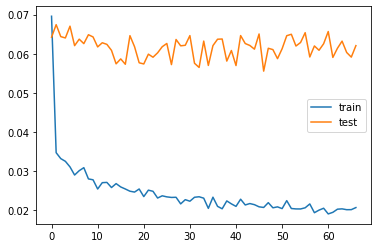

(77, 7)
(77, 7)
(77, 7)
score_train: [15.410] 15.0, 15.4, 15.6, 15.5, 15.7, 14.9, 15.8
(15, 1, 5)
score_test: [29.146] 15.9, 41.7, 41.9, 29.0, 24.0, 17.2, 22.1

RMSE test:  29.146211891814723 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0947 - val_loss: 0.0656
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0681
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0671
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0609
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0619
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0633
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0612
Epoch 8/1000
77/77 [=====================

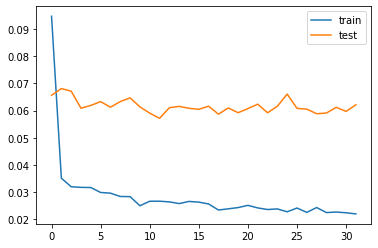

(77, 7)
(77, 7)
(77, 7)
score_train: [16.253] 15.8, 16.0, 16.3, 16.2, 16.9, 16.1, 16.4
(15, 1, 5)
score_test: [29.162] 19.2, 39.7, 45.2, 28.2, 18.6, 19.1, 21.4

RMSE test:  29.16232819050642 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0686
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0634
Epoch 3/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0641
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0657
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0655
Epoch 6/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0638
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0648
Epoch 8/1000
77/77 [======================

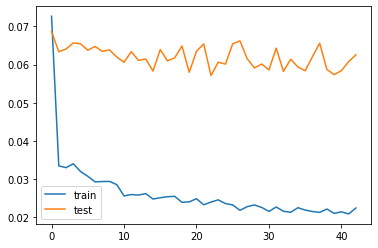

(77, 7)
(77, 7)
(77, 7)
score_train: [16.027] 15.7, 15.7, 16.2, 15.9, 16.6, 15.8, 16.2
(15, 1, 5)
score_test: [29.262] 24.8, 39.0, 45.1, 26.9, 18.5, 15.9, 22.4

RMSE test:  29.26201464227571 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0731 - val_loss: 0.0652
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0669
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0616
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0712
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0668
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0638
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0621
Epoch 8/1000
77/77 [======================

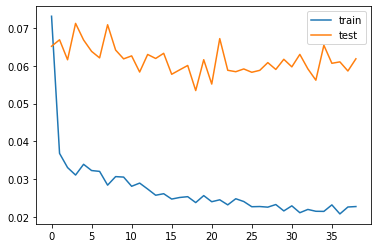

(77, 7)
(77, 7)
(77, 7)
score_train: [15.969] 15.5, 15.6, 16.3, 15.9, 16.4, 15.8, 16.3
(15, 1, 5)
score_test: [29.097] 19.3, 41.9, 44.2, 29.4, 17.6, 16.8, 19.6

RMSE test:  29.097109565202047 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0811 - val_loss: 0.0620
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.0665
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0667
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0691
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0666
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0671
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0656
Epoch 8/1000
77/77 [=====================

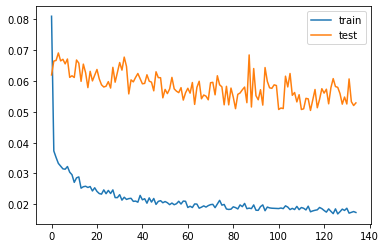

(77, 7)
(77, 7)
(77, 7)
score_train: [14.573] 13.9, 14.1, 15.1, 14.9, 15.2, 14.0, 14.7
(15, 1, 5)
score_test: [26.913] 15.7, 38.4, 39.8, 30.5, 21.4, 10.6, 16.1

RMSE test:  26.912847636420718 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0973 - val_loss: 0.0742
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0704
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0665
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0667
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0655
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0648
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0695
Epoch 8/1000
77/77 [=====================

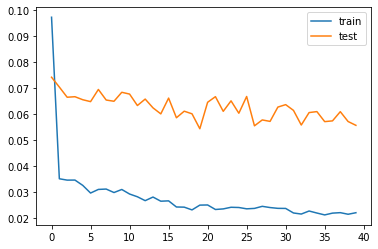

(77, 7)
(77, 7)
(77, 7)
score_train: [16.139] 15.7, 15.8, 16.4, 16.3, 16.7, 15.7, 16.3
(15, 1, 5)
score_test: [27.608] 19.1, 40.8, 42.7, 26.4, 16.7, 14.3, 17.4

RMSE test:  27.608330401337874 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0784 - val_loss: 0.0624
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0624
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0589
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0628
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0616
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0642
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0580
Epoch 8/1000
77/77 [=====================

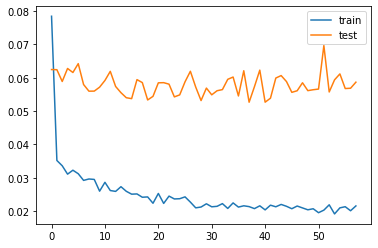

(77, 7)
(77, 7)
(77, 7)
score_train: [15.659] 15.3, 15.4, 15.8, 15.8, 15.9, 15.5, 15.9
(15, 1, 5)
score_test: [28.337] 18.7, 36.7, 42.1, 26.9, 23.0, 20.4, 22.0

RMSE test:  28.337096171009406 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.1070 - val_loss: 0.0670
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0589
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0598
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0599
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0606
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0620
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0582
Epoch 8/1000
77/77 [=====================

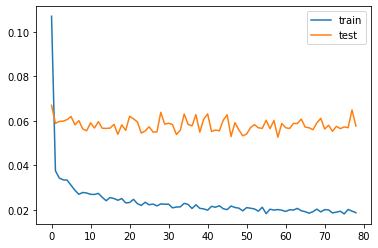

(77, 7)
(77, 7)
(77, 7)
score_train: [15.238] 15.1, 15.4, 15.5, 15.4, 15.6, 14.6, 15.1
(15, 1, 5)
score_test: [28.106] 19.5, 41.2, 43.3, 29.5, 18.9, 9.9, 15.8

RMSE test:  28.10635143765449 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0887 - val_loss: 0.0748
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0702
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0645
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0680
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0658
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0596
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0642
Epoch 8/1000
77/77 [=======================

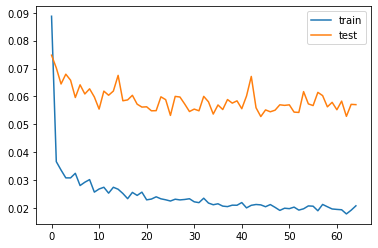

(77, 7)
(77, 7)
(77, 7)
score_train: [15.326] 14.9, 14.9, 15.5, 15.4, 15.6, 15.4, 15.7
(15, 1, 5)
score_test: [27.948] 18.5, 37.5, 41.6, 29.1, 18.7, 20.0, 19.8

RMSE test:  27.94814621429809 

2  	9     	26.8681	0       	26.8681	26.8681

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 1s 7ms/step - loss: 0.0753 - val_loss: 0.0779
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0749
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0681
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0724
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0718
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0640
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.066

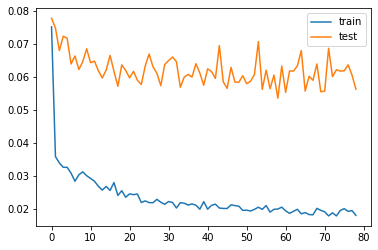

(77, 7)
(77, 7)
(77, 7)
score_train: [15.176] 14.6, 15.4, 15.4, 15.2, 15.9, 14.6, 15.1
(15, 1, 5)
score_test: [27.785] 17.6, 40.8, 41.5, 30.7, 18.4, 14.4, 14.7

RMSE test:  27.784853611565534 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0620
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0615
Epoch 3/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0670
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0615
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0591
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0574
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0586
Epoch 8/1000
77/77 [=====================

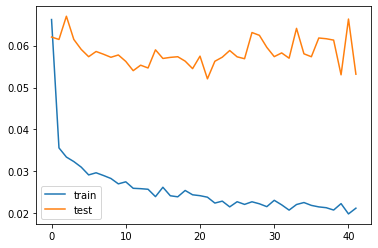

(77, 7)
(77, 7)
(77, 7)
score_train: [15.953] 15.6, 16.1, 16.0, 15.9, 16.2, 15.7, 16.0
(15, 1, 5)
score_test: [26.981] 18.1, 37.9, 41.6, 26.4, 16.6, 17.5, 18.3

RMSE test:  26.981406508001346 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0851 - val_loss: 0.0686
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0644
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0367 - val_loss: 0.0613
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0690
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0649
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0619
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0626
Epoch 8/1000
77/77 [=====================

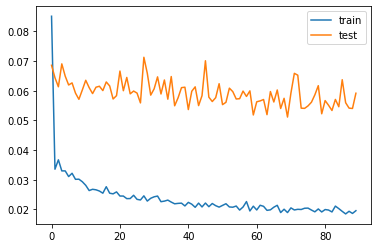

(77, 7)
(77, 7)
(77, 7)
score_train: [15.193] 14.9, 14.9, 15.6, 15.2, 15.5, 14.7, 15.5
(15, 1, 5)
score_test: [28.455] 19.2, 37.5, 43.0, 29.4, 23.5, 17.4, 17.9

RMSE test:  28.454601880330035 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0704 - val_loss: 0.0803
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0369 - val_loss: 0.0706
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0721
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0722
Epoch 5/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0678
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0671
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0653
Epoch 8/1000
77/77 [=====================

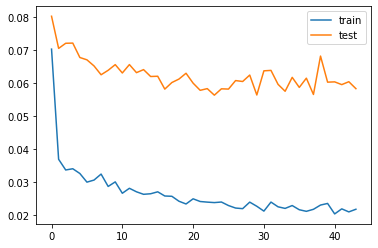

(77, 7)
(77, 7)
(77, 7)
score_train: [16.060] 15.8, 15.7, 16.1, 16.4, 16.6, 15.6, 16.2
(15, 1, 5)
score_test: [28.268] 18.4, 40.8, 42.2, 29.3, 18.5, 17.4, 17.6

RMSE test:  28.268221878939684 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0722
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0626
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0600
Epoch 4/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0697
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0644
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0657
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0623
Epoch 8/1000
77/77 [=====================

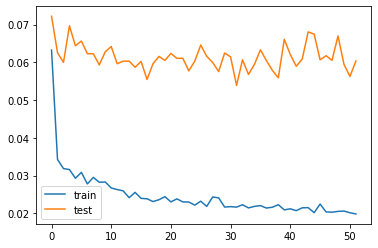

(77, 7)
(77, 7)
(77, 7)
score_train: [15.546] 15.2, 15.2, 15.7, 15.6, 16.1, 14.9, 16.0
(15, 1, 5)
score_test: [28.742] 18.4, 39.2, 44.0, 26.8, 18.1, 19.4, 23.5

RMSE test:  28.74225742541593 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0673
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0371 - val_loss: 0.0666
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0681
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0656
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0630
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0636
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0656
Epoch 8/1000
77/77 [======================

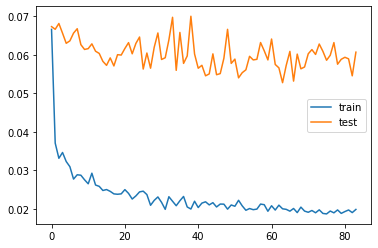

(77, 7)
(77, 7)
(77, 7)
score_train: [15.451] 15.0, 15.5, 15.6, 15.9, 15.7, 14.9, 15.6
(15, 1, 5)
score_test: [28.820] 20.9, 40.5, 43.4, 27.5, 23.3, 14.4, 18.3

RMSE test:  28.819798031650716 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0642
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0618
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0616
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0637
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0653
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0594
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0607
Epoch 8/1000
77/77 [=====================

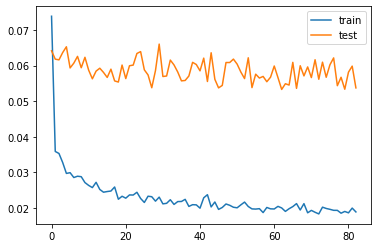

(77, 7)
(77, 7)
(77, 7)
score_train: [15.249] 14.6, 15.1, 15.6, 15.4, 15.4, 15.1, 15.5
(15, 1, 5)
score_test: [27.124] 17.7, 37.6, 40.3, 30.8, 19.2, 15.2, 15.8

RMSE test:  27.123583773455245 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0693
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0622
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0642
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0626
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0644
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0645
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0625
Epoch 8/1000
77/77 [=====================

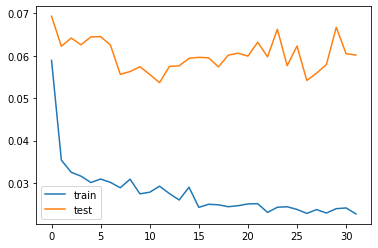

(77, 7)
(77, 7)
(77, 7)
score_train: [16.298] 15.8, 16.1, 16.5, 16.0, 16.6, 16.0, 17.1
(15, 1, 5)
score_test: [28.698] 22.1, 38.4, 44.6, 28.8, 17.6, 16.2, 20.1

RMSE test:  28.69821082224473 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 1s 7ms/step - loss: 0.0669 - val_loss: 0.0698
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0638
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0640
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0670
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0640
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0621
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0582
Epoch 8/1000
77/77 [======================

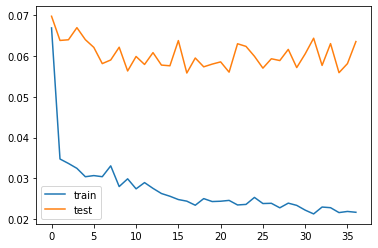

(77, 7)
(77, 7)
(77, 7)
score_train: [16.339] 15.7, 15.9, 16.9, 16.2, 17.1, 16.1, 16.4
(15, 1, 5)
score_test: [29.500] 18.3, 38.9, 44.4, 26.0, 22.2, 23.9, 23.1

RMSE test:  29.4999400205301 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0917 - val_loss: 0.0656
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0635
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0650
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0624
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0631
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0620
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0613
Epoch 8/1000
77/77 [=======================

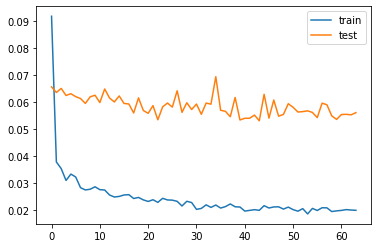

(77, 7)
(77, 7)
(77, 7)
score_train: [15.534] 15.2, 15.5, 15.6, 15.5, 15.9, 15.4, 15.6
(15, 1, 5)
score_test: [27.708] 17.9, 37.4, 42.0, 27.9, 19.5, 17.8, 20.3

RMSE test:  27.708003810087824 

3  	10    	26.8681	0       	26.8681	26.8681

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0744 - val_loss: 0.0654
Epoch 2/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0610
Epoch 3/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0581
Epoch 4/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0593
Epoch 5/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0636
Epoch 6/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0630
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.06

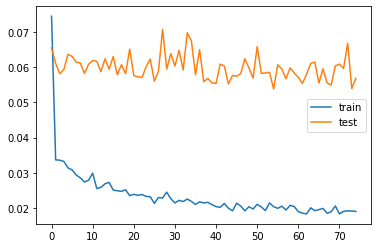

(77, 7)
(77, 7)
(77, 7)
score_train: [15.231] 14.9, 15.1, 15.6, 15.6, 15.5, 14.6, 15.3
(15, 1, 5)
score_test: [27.884] 19.8, 40.3, 42.1, 30.4, 20.5, 9.7, 14.7

RMSE test:  27.88374797035021 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0698 - val_loss: 0.0651
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0630
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0653
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0690
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0605
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0624
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0627
Epoch 8/1000
77/77 [=======================

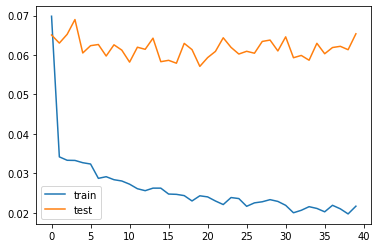

(77, 7)
(77, 7)
(77, 7)
score_train: [16.230] 15.7, 15.7, 16.3, 16.2, 16.6, 16.1, 16.9
(15, 1, 5)
score_test: [29.919] 19.7, 40.8, 44.8, 25.7, 21.1, 21.3, 25.3

RMSE test:  29.918664914739512 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0707 - val_loss: 0.0734
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0673
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0684
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0639
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0660
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0677
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0649
Epoch 8/1000
77/77 [=====================

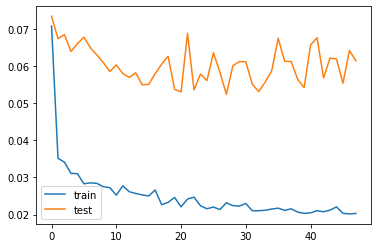

(77, 7)
(77, 7)
(77, 7)
score_train: [15.825] 15.1, 15.6, 15.9, 15.9, 16.6, 15.5, 16.2
(15, 1, 5)
score_test: [28.989] 18.3, 40.1, 43.7, 26.7, 22.8, 18.4, 21.4

RMSE test:  28.98851888222479 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0643
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0593
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0657
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0586
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0619
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0357 - val_loss: 0.0618
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0668
Epoch 8/1000
77/77 [======================

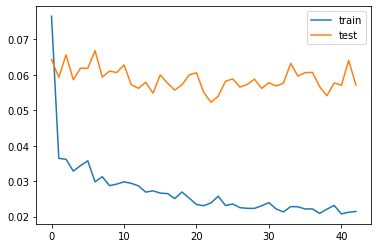

(77, 7)
(77, 7)
(77, 7)
score_train: [15.947] 15.6, 15.6, 16.4, 15.8, 16.2, 15.8, 16.2
(15, 1, 5)
score_test: [27.973] 15.2, 39.2, 39.7, 27.5, 19.5, 23.2, 21.4

RMSE test:  27.97282078543513 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0708
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0664
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0676
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0624
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0625
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0677
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0666
Epoch 8/1000
77/77 [======================

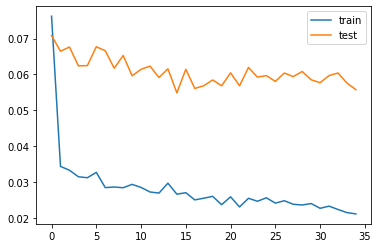

(77, 7)
(77, 7)
(77, 7)
score_train: [16.560] 15.7, 16.0, 17.0, 16.5, 17.4, 16.6, 16.7
(15, 1, 5)
score_test: [27.623] 19.4, 41.0, 42.4, 28.1, 12.3, 15.3, 17.5

RMSE test:  27.622703599028686 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0901 - val_loss: 0.0574
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0389 - val_loss: 0.0639
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0358 - val_loss: 0.0642
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0688
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0639
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0650
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0660
Epoch 8/1000
77/77 [=====================

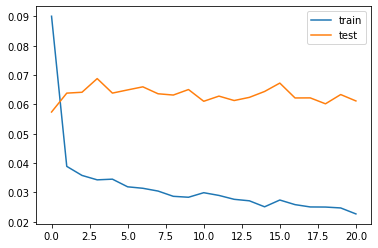

(77, 7)
(77, 7)
(77, 7)
score_train: [16.931] 16.1, 16.9, 16.6, 16.9, 17.4, 17.1, 17.5
(15, 1, 5)
score_test: [28.946] 22.9, 40.3, 46.4, 24.5, 15.1, 16.8, 21.3

RMSE test:  28.945926713981695 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 1s 7ms/step - loss: 0.0768 - val_loss: 0.0647
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0687
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0639
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0604
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0624
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0626
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0610
Epoch 8/1000
77/77 [=====================

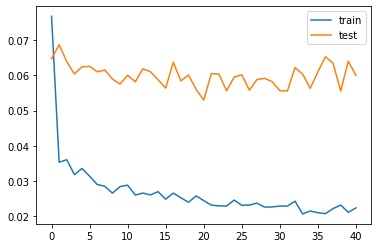

(77, 7)
(77, 7)
(77, 7)
score_train: [16.015] 15.5, 15.7, 16.7, 15.8, 16.5, 15.7, 16.2
(15, 1, 5)
score_test: [28.659] 20.7, 40.2, 46.2, 26.1, 17.2, 15.5, 18.7

RMSE test:  28.658718615560822 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0662
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0655
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0634
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0617
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0629
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0682
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0634
Epoch 8/1000
77/77 [=====================

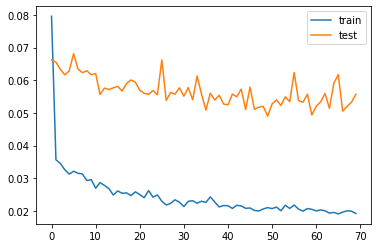

(77, 7)
(77, 7)
(77, 7)
score_train: [15.479] 15.1, 15.1, 15.7, 15.6, 16.0, 14.9, 15.9
(15, 1, 5)
score_test: [27.615] 18.4, 36.5, 40.9, 29.0, 19.8, 17.4, 21.3

RMSE test:  27.615175390889355 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0633
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0400 - val_loss: 0.0596
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0635
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0653
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0690
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0675
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0621
Epoch 8/1000
77/77 [=====================

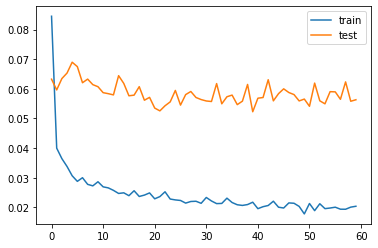

(77, 7)
(77, 7)
(77, 7)
score_train: [15.427] 15.7, 15.3, 15.6, 15.6, 15.6, 14.8, 15.4
(15, 1, 5)
score_test: [27.766] 19.9, 40.0, 42.9, 27.6, 18.4, 12.8, 17.2

RMSE test:  27.76620179302697 

4  	9     	26.8681	0       	26.8681	26.8681

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0612
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0371 - val_loss: 0.0613
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0614
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0655
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0627
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0648
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.066

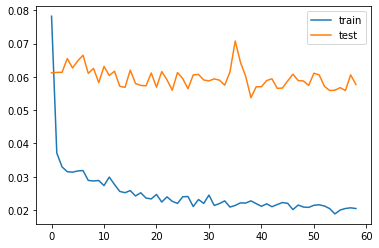

(77, 7)
(77, 7)
(77, 7)
score_train: [15.628] 15.3, 15.3, 15.8, 15.8, 15.8, 15.5, 15.9
(15, 1, 5)
score_test: [28.110] 21.1, 38.3, 41.5, 28.0, 20.0, 18.6, 19.3

RMSE test:  28.10976668936989 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0698
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0371 - val_loss: 0.0690
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0361 - val_loss: 0.0692
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0678
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0659
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0694
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0647
Epoch 8/1000
77/77 [======================

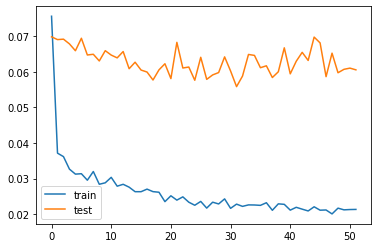

(77, 7)
(77, 7)
(77, 7)
score_train: [16.042] 15.4, 16.0, 16.3, 16.6, 16.5, 15.4, 16.0
(15, 1, 5)
score_test: [28.788] 19.4, 41.3, 45.7, 24.4, 18.4, 16.8, 20.2

RMSE test:  28.787919971612688 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0706 - val_loss: 0.0664
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0686
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0637
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0607
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0657
Epoch 6/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0664
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0659
Epoch 8/1000
77/77 [=====================

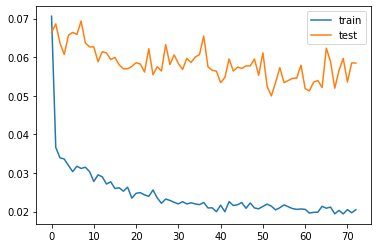

(77, 7)
(77, 7)
(77, 7)
score_train: [15.663] 15.2, 15.4, 15.8, 15.7, 16.1, 15.4, 16.2
(15, 1, 5)
score_test: [28.294] 19.9, 36.0, 43.6, 27.7, 21.5, 18.6, 20.9

RMSE test:  28.293602532041206 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0757
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0697
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0708
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0688
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0661
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0686
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0654
Epoch 8/1000
77/77 [=====================

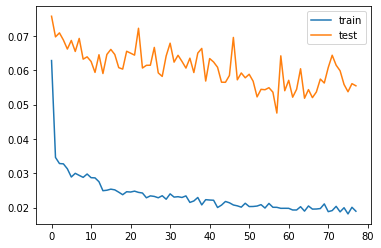

(77, 7)
(77, 7)
(77, 7)
score_train: [15.203] 14.7, 14.9, 15.5, 15.3, 15.6, 15.0, 15.3
(15, 1, 5)
score_test: [27.550] 18.2, 37.4, 41.0, 31.2, 19.4, 16.7, 16.7

RMSE test:  27.55043325860967 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0822 - val_loss: 0.0645
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0636
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0616
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0644
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0674
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0622
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0650
Epoch 8/1000
77/77 [======================

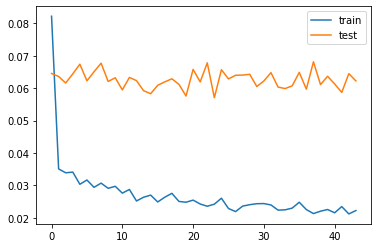

(77, 7)
(77, 7)
(77, 7)
score_train: [16.162] 15.5, 16.1, 16.2, 16.3, 16.6, 16.2, 16.3
(15, 1, 5)
score_test: [29.183] 18.5, 41.0, 43.8, 25.7, 19.1, 21.7, 22.8

RMSE test:  29.182553917621302 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 6ms/step - loss: 0.0621 - val_loss: 0.0678
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0660
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0673
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0595
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0625
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0694
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0641
Epoch 8/1000
77/77 [=====================

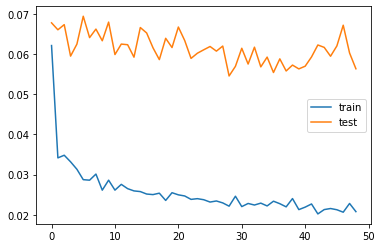

(77, 7)
(77, 7)
(77, 7)
score_train: [15.959] 15.4, 15.6, 16.1, 16.2, 16.3, 15.7, 16.2
(15, 1, 5)
score_test: [27.767] 19.6, 40.6, 43.4, 28.4, 13.9, 13.5, 17.3

RMSE test:  27.76726693422955 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0786 - val_loss: 0.0692
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0371 - val_loss: 0.0719
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0665
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0637
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0679
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0600
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0627
Epoch 8/1000
77/77 [======================

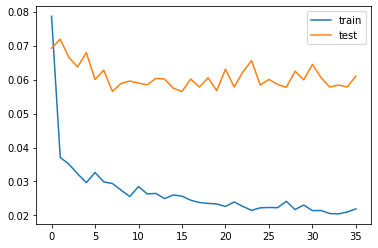

(77, 7)
(77, 7)
(77, 7)
score_train: [16.117] 15.6, 16.0, 16.1, 16.0, 16.7, 15.8, 16.6
(15, 1, 5)
score_test: [28.896] 19.0, 39.7, 43.5, 26.0, 21.2, 19.5, 22.5

RMSE test:  28.896455516016392 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0794 - val_loss: 0.0769
Epoch 2/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0744
Epoch 3/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0676
Epoch 4/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0696
Epoch 5/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0699
Epoch 6/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0637
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0678
Epoch 8/1000
77/77 [=====================

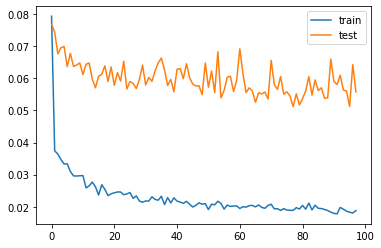

(77, 7)
(77, 7)
(77, 7)
score_train: [15.133] 14.8, 14.7, 15.4, 15.6, 15.5, 14.6, 15.3
(15, 1, 5)
score_test: [27.635] 20.7, 37.4, 43.5, 31.2, 19.4, 10.2, 13.2

RMSE test:  27.634634554803007 

5  	8     	26.8681	0       	26.8681	26.8681

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0848 - val_loss: 0.0665
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0707
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0640
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0635
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0618
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0594
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.06

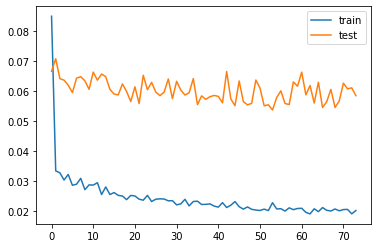

(77, 7)
(77, 7)
(77, 7)
score_train: [15.481] 15.3, 15.2, 15.8, 15.6, 15.6, 15.0, 15.8
(15, 1, 5)
score_test: [28.262] 18.8, 39.0, 40.1, 28.9, 22.6, 19.0, 20.2

RMSE test:  28.262077239941426 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0646
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0638
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0656
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0699
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0646
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0624
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0645
Epoch 8/1000
77/77 [=====================

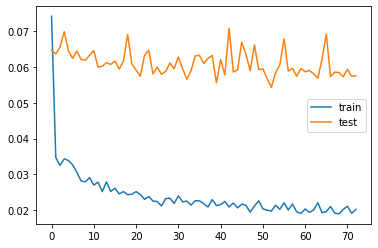

(77, 7)
(77, 7)
(77, 7)
score_train: [15.256] 15.1, 15.0, 15.6, 15.3, 15.7, 14.5, 15.6
(15, 1, 5)
score_test: [28.075] 19.2, 40.7, 42.5, 28.9, 21.8, 11.7, 15.4

RMSE test:  28.075249830347353 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0836 - val_loss: 0.0679
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0355 - val_loss: 0.0658
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0623
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0664
Epoch 5/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0650
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0662
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0662
Epoch 8/1000
77/77 [=====================

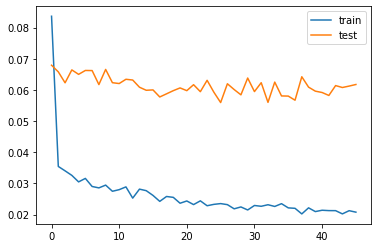

(77, 7)
(77, 7)
(77, 7)
score_train: [15.861] 15.5, 15.6, 15.9, 15.9, 16.4, 15.6, 16.1
(15, 1, 5)
score_test: [29.071] 18.1, 41.0, 43.0, 27.8, 21.4, 20.9, 19.7

RMSE test:  29.071331139172962 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.0596
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0590
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0575
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0607
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0560
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0556
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0566
Epoch 8/1000
77/77 [=====================

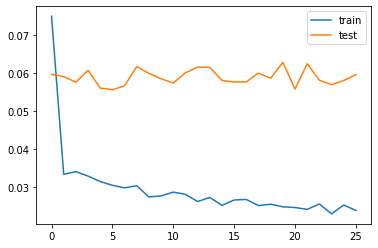

(77, 7)
(77, 7)
(77, 7)
score_train: [16.504] 15.9, 16.4, 16.6, 16.4, 16.8, 16.6, 16.8
(15, 1, 5)
score_test: [28.550] 20.6, 41.2, 43.6, 29.8, 15.2, 13.6, 19.4

RMSE test:  28.549941401405682 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0879 - val_loss: 0.0639
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0607
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0619
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0612
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0637
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0656
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0627
Epoch 8/1000
77/77 [=====================

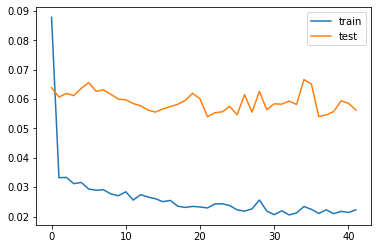

(77, 7)
(77, 7)
(77, 7)
score_train: [15.889] 15.3, 15.7, 16.0, 15.8, 16.1, 15.9, 16.3
(15, 1, 5)
score_test: [27.760] 19.5, 37.7, 41.9, 27.9, 18.8, 17.6, 19.8

RMSE test:  27.760482335180203 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 1s 7ms/step - loss: 0.0851 - val_loss: 0.0648
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0627
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0647
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0653
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0645
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0649
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0655
Epoch 8/1000
77/77 [=====================

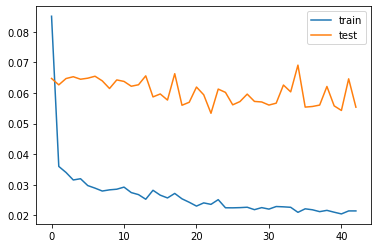

(77, 7)
(77, 7)
(77, 7)
score_train: [15.982] 15.6, 15.7, 15.8, 16.0, 16.5, 15.6, 16.5
(15, 1, 5)
score_test: [27.530] 19.5, 37.5, 42.5, 30.7, 14.2, 16.7, 17.1

RMSE test:  27.530461264065337 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0762
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0358 - val_loss: 0.0715
Epoch 3/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0700
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0723
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0724
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0652
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0671
Epoch 8/1000
77/77 [=====================

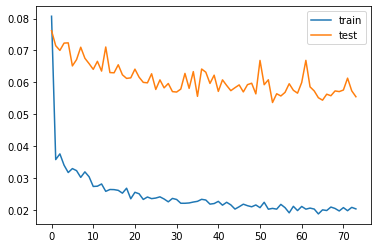

(77, 7)
(77, 7)
(77, 7)
score_train: [15.519] 15.2, 15.1, 15.6, 15.8, 15.9, 15.3, 15.8
(15, 1, 5)
score_test: [27.566] 16.7, 38.1, 42.1, 29.5, 17.1, 16.0, 19.7

RMSE test:  27.56589418757643 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0645
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0612
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0638
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0608
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0614
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0594
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0606
Epoch 8/1000
77/77 [======================

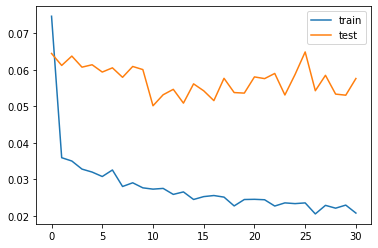

(77, 7)
(77, 7)
(77, 7)
score_train: [16.282] 15.7, 16.0, 16.4, 16.3, 16.6, 16.2, 16.7
(15, 1, 5)
score_test: [28.091] 20.0, 38.3, 44.7, 28.1, 16.3, 15.8, 18.8

RMSE test:  28.090862314827806 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0712 - val_loss: 0.0620
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0576
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0616
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0641
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0619
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0602
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0614
Epoch 8/1000
77/77 [=====================

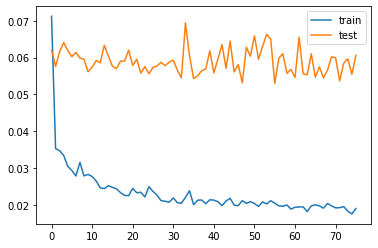

(77, 7)
(77, 7)
(77, 7)
score_train: [15.179] 14.9, 14.9, 15.7, 15.4, 15.4, 14.8, 15.1
(15, 1, 5)
score_test: [28.800] 20.1, 37.7, 42.4, 29.7, 25.3, 16.8, 19.4

RMSE test:  28.800394314094525 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0875 - val_loss: 0.0706
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0387 - val_loss: 0.0659
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0641
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0630
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0631
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0612
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0615
Epoch 8/1000
77/77 [=====================

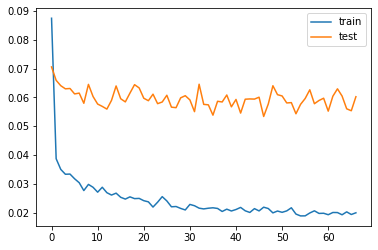

(77, 7)
(77, 7)
(77, 7)
score_train: [15.363] 15.0, 15.3, 15.7, 15.6, 15.6, 14.8, 15.6
(15, 1, 5)
score_test: [28.717] 17.2, 42.0, 42.6, 28.5, 22.0, 15.6, 19.0

RMSE test:  28.717166818765566 

6  	10    	26.8681	0       	26.8681	26.8681

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0871 - val_loss: 0.0610
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0624
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0657
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0639
Epoch 5/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0661
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0656
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.06

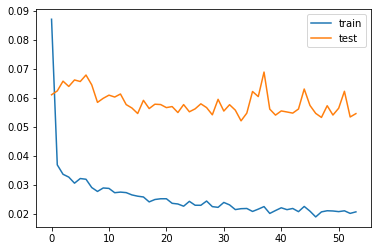

(77, 7)
(77, 7)
(77, 7)
score_train: [15.640] 15.1, 15.5, 15.8, 15.7, 15.9, 15.4, 15.9
(15, 1, 5)
score_test: [27.319] 17.9, 38.6, 42.9, 28.6, 14.3, 16.4, 16.7

RMSE test:  27.31933870228364 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0874 - val_loss: 0.0601
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0596
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0644
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0632
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0629
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0605
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0624
Epoch 8/1000
77/77 [======================

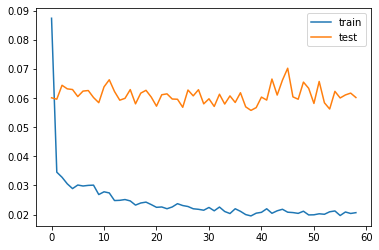

(77, 7)
(77, 7)
(77, 7)
score_train: [15.467] 15.3, 15.3, 15.7, 15.4, 15.9, 14.9, 15.8
(15, 1, 5)
score_test: [28.701] 18.2, 41.0, 43.8, 29.0, 21.1, 15.4, 17.7

RMSE test:  28.70096067541787 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0795 - val_loss: 0.0675
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0646
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0633
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0666
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0655
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0647
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0643
Epoch 8/1000
77/77 [======================

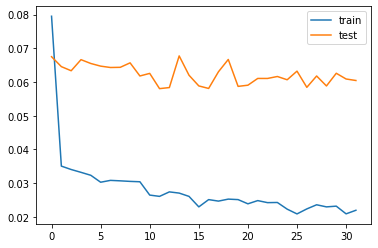

(77, 7)
(77, 7)
(77, 7)
score_train: [16.328] 15.6, 15.9, 16.2, 16.5, 16.7, 16.3, 17.0
(15, 1, 5)
score_test: [28.767] 17.4, 40.0, 41.9, 30.4, 17.8, 18.3, 23.6

RMSE test:  28.766987499288735 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0583
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0577
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0584
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0580
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0602
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0587
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0582
Epoch 8/1000
77/77 [=====================

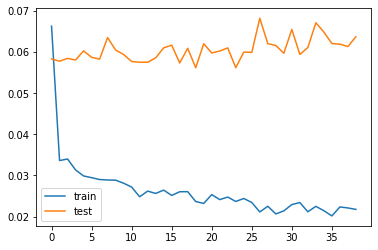

(77, 7)
(77, 7)
(77, 7)
score_train: [16.028] 15.8, 16.0, 16.1, 15.8, 16.3, 15.9, 16.3
(15, 1, 5)
score_test: [29.523] 21.1, 41.5, 44.5, 28.1, 18.7, 18.8, 21.3

RMSE test:  29.5226168998457 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0789 - val_loss: 0.0689
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0358 - val_loss: 0.0671
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0358 - val_loss: 0.0671
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0639
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0670
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0664
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0647
Epoch 8/1000
77/77 [=======================

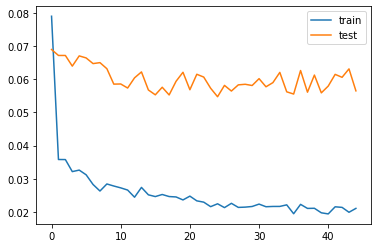

(77, 7)
(77, 7)
(77, 7)
score_train: [15.691] 15.3, 15.4, 15.9, 15.8, 16.0, 15.6, 15.7
(15, 1, 5)
score_test: [27.805] 18.5, 39.4, 43.4, 28.3, 17.1, 13.3, 19.0

RMSE test:  27.804842093188363 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0748 - val_loss: 0.0609
Epoch 2/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0626
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0596
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0636
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0624
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0659
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0642
Epoch 8/1000
77/77 [=====================

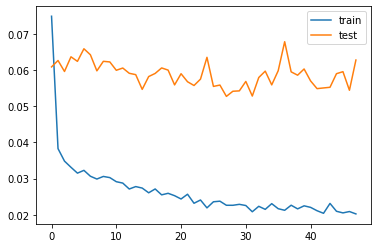

(77, 7)
(77, 7)
(77, 7)
score_train: [16.373] 15.8, 16.1, 16.5, 15.8, 16.9, 16.8, 16.7
(15, 1, 5)
score_test: [29.309] 19.4, 38.1, 45.0, 25.1, 20.4, 23.5, 23.8

RMSE test:  29.308866883137085 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0812 - val_loss: 0.0659
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0660
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0638
Epoch 4/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0594
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0626
Epoch 6/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0629
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0600
Epoch 8/1000
77/77 [=====================

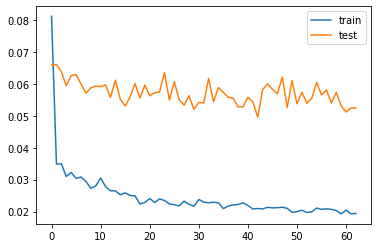

(77, 7)
(77, 7)
(77, 7)
score_train: [15.667] 15.2, 15.4, 15.7, 15.7, 16.3, 15.4, 16.0
(15, 1, 5)
score_test: [26.785] 16.6, 37.6, 40.3, 30.6, 13.7, 15.3, 18.8

RMSE test:  26.784561315807586 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0813 - val_loss: 0.0659
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0643
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0656
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0624
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0660
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0636
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0631
Epoch 8/1000
77/77 [=====================

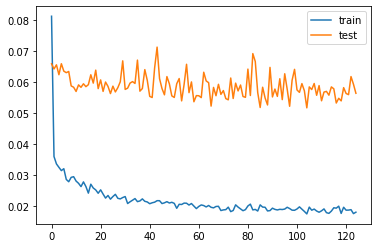

(77, 7)
(77, 7)
(77, 7)
score_train: [14.851] 14.5, 14.6, 15.3, 15.3, 15.2, 14.2, 14.8
(15, 1, 5)
score_test: [27.789] 17.8, 37.9, 41.1, 31.3, 24.8, 9.6, 16.6

RMSE test:  27.788811447235467 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0840 - val_loss: 0.0711
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0409 - val_loss: 0.0657
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0695
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0651
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0649
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0651
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0608
Epoch 8/1000
77/77 [======================

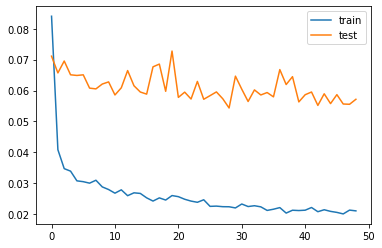

(77, 7)
(77, 7)
(77, 7)
score_train: [15.836] 15.5, 15.8, 15.8, 15.9, 16.2, 15.5, 16.1
(15, 1, 5)
score_test: [27.973] 20.3, 38.9, 43.6, 30.4, 15.2, 14.6, 16.9

RMSE test:  27.973347502466204 

7  	9     	26.843 	0.0382744	26.7846	26.8681

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0869 - val_loss: 0.0741
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0693
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0671
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0654
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0648
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0636
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0

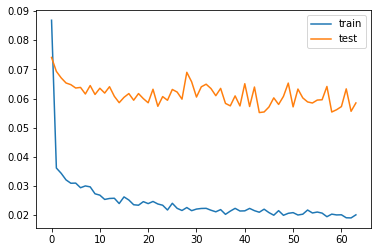

(77, 7)
(77, 7)
(77, 7)
score_train: [15.422] 15.0, 15.2, 15.8, 15.5, 15.9, 14.8, 15.7
(15, 1, 5)
score_test: [28.302] 17.3, 41.3, 42.7, 29.4, 18.1, 15.8, 18.2

RMSE test:  28.302118781714693 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0673 - val_loss: 0.0705
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0604
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0635
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0654
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0612
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0615
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0605
Epoch 8/1000
77/77 [=====================

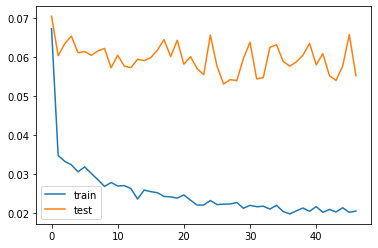

(77, 7)
(77, 7)
(77, 7)
score_train: [15.865] 15.4, 15.6, 15.8, 15.9, 16.9, 15.6, 15.8
(15, 1, 5)
score_test: [27.508] 20.7, 38.9, 43.9, 29.1, 13.5, 11.3, 16.3

RMSE test:  27.508117162883924 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0759 - val_loss: 0.0627
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0384 - val_loss: 0.0615
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0608
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0606
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0568
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0595
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0633
Epoch 8/1000
77/77 [=====================

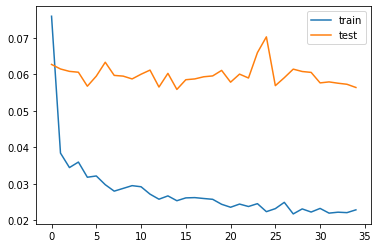

(77, 7)
(77, 7)
(77, 7)
score_train: [16.171] 15.6, 16.0, 16.4, 15.9, 16.5, 16.4, 16.5
(15, 1, 5)
score_test: [27.790] 19.2, 38.7, 42.4, 26.6, 15.8, 18.1, 21.4

RMSE test:  27.790003182989658 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0889 - val_loss: 0.0695
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0652
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0654
Epoch 4/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0679
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0624
Epoch 6/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0626
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0662
Epoch 8/1000
77/77 [=====================

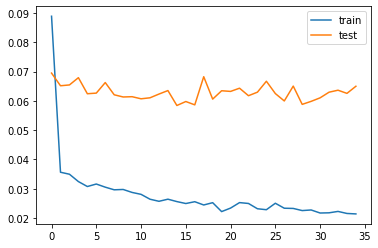

(77, 7)
(77, 7)
(77, 7)
score_train: [16.212] 15.7, 16.3, 16.2, 16.0, 16.7, 16.2, 16.3
(15, 1, 5)
score_test: [29.826] 19.7, 42.3, 44.8, 28.7, 19.3, 18.0, 22.7

RMSE test:  29.826256772732265 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0717 - val_loss: 0.0653
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0648
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0617
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0665
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0618
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0675
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0620
Epoch 8/1000
77/77 [=====================

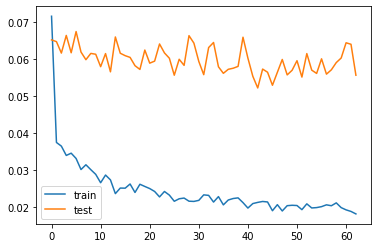

(77, 7)
(77, 7)
(77, 7)
score_train: [15.718] 15.6, 15.3, 15.9, 15.8, 16.5, 15.1, 15.7
(15, 1, 5)
score_test: [27.612] 21.3, 39.9, 41.4, 31.3, 14.5, 12.6, 15.1

RMSE test:  27.61184557009608 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0869 - val_loss: 0.0691
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0697
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0642
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0639
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0633
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0618
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0614
Epoch 8/1000
77/77 [======================

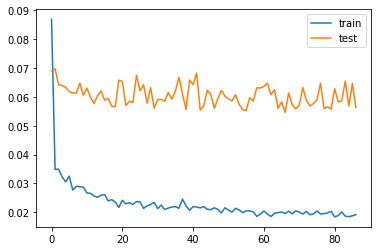

(77, 7)
(77, 7)
(77, 7)
score_train: [15.368] 14.8, 15.1, 16.0, 15.4, 16.0, 14.9, 15.3
(15, 1, 5)
score_test: [27.756] 21.9, 40.9, 41.6, 30.6, 16.5, 9.8, 14.3

RMSE test:  27.755575053896134 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0725 - val_loss: 0.0636
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0633
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0639
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0634
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0629
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0628
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0637
Epoch 8/1000
77/77 [======================

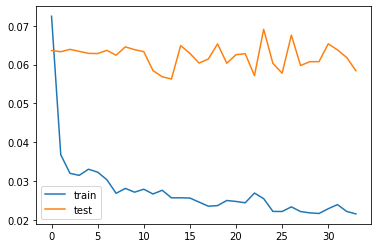

(77, 7)
(77, 7)
(77, 7)
score_train: [16.209] 15.5, 16.0, 16.2, 16.0, 16.7, 16.1, 16.9
(15, 1, 5)
score_test: [28.278] 16.3, 40.6, 41.7, 28.5, 17.2, 19.2, 21.5

RMSE test:  28.277951425294447 

8  	7     	26.8013	0.0334086	26.7846	26.8681

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0694 - val_loss: 0.0658
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0374 - val_loss: 0.0678
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0667
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0651
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0639
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0647
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0

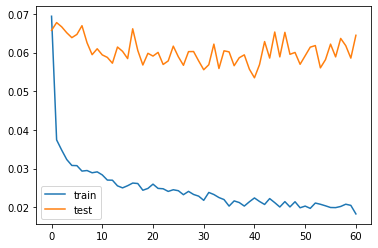

(77, 7)
(77, 7)
(77, 7)
score_train: [16.172] 16.2, 16.7, 16.8, 16.2, 16.5, 15.1, 15.7
(15, 1, 5)
score_test: [29.710] 21.6, 43.0, 47.1, 24.2, 21.2, 16.4, 18.4

RMSE test:  29.710481655338555 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0841 - val_loss: 0.0779
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0712
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0662
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0653
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0632
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0672
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0626
Epoch 8/1000
77/77 [=====================

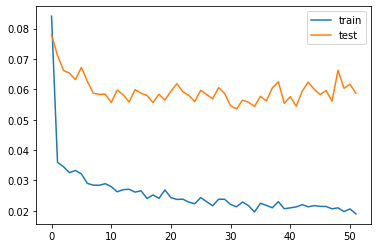

(77, 7)
(77, 7)
(77, 7)
score_train: [15.595] 15.3, 15.3, 15.9, 15.7, 16.1, 15.1, 15.8
(15, 1, 5)
score_test: [28.343] 18.5, 39.7, 43.2, 26.7, 18.7, 17.7, 21.4

RMSE test:  28.343055383913573 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0594
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0624
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0619
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0668
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0634
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0648
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0656
Epoch 8/1000
77/77 [=====================

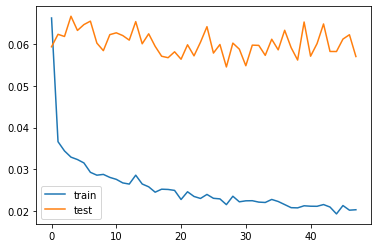

(77, 7)
(77, 7)
(77, 7)
score_train: [15.738] 15.4, 15.7, 15.9, 15.8, 16.0, 15.4, 15.9
(15, 1, 5)
score_test: [27.955] 18.5, 38.3, 43.0, 27.9, 18.5, 17.2, 19.8

RMSE test:  27.95495983629561 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0848 - val_loss: 0.0628
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0627
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0613
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0601
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0647
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0661
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0625
Epoch 8/1000
77/77 [======================

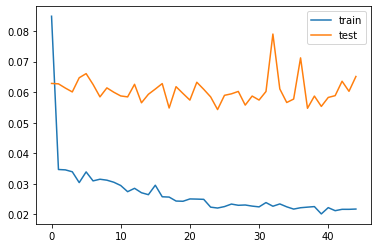

(77, 7)
(77, 7)
(77, 7)
score_train: [16.137] 15.5, 15.5, 16.4, 16.2, 16.9, 15.7, 16.6
(15, 1, 5)
score_test: [29.856] 17.6, 40.6, 45.9, 25.0, 21.4, 21.4, 25.2

RMSE test:  29.8564783792817 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0700
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0739
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0669
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0675
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0639
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0671
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0640
Epoch 8/1000
77/77 [=======================

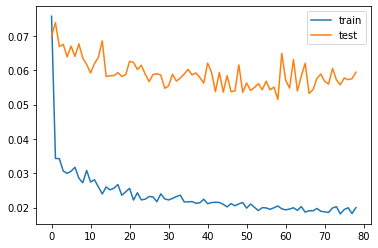

(77, 7)
(77, 7)
(77, 7)
score_train: [15.157] 14.7, 15.0, 15.6, 15.6, 15.5, 14.5, 15.2
(15, 1, 5)
score_test: [28.525] 16.8, 40.8, 42.3, 28.6, 23.0, 16.6, 18.3

RMSE test:  28.525378812364703 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 1s 7ms/step - loss: 0.0800 - val_loss: 0.0632
Epoch 2/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0641
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0357 - val_loss: 0.0624
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0611
Epoch 5/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0666
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0619
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0575
Epoch 8/1000
77/77 [=====================

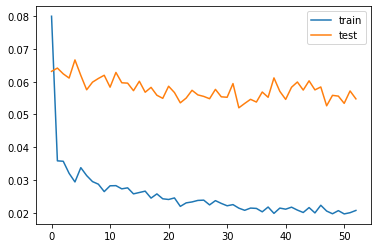

(77, 7)
(77, 7)
(77, 7)
score_train: [15.508] 15.2, 15.2, 15.6, 15.5, 16.1, 14.9, 16.0
(15, 1, 5)
score_test: [27.376] 17.6, 40.0, 42.2, 27.2, 17.5, 14.1, 17.7

RMSE test:  27.376395114992008 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0770 - val_loss: 0.0597
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0579
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0593
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0632
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0611
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0615
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0616
Epoch 8/1000
77/77 [=====================

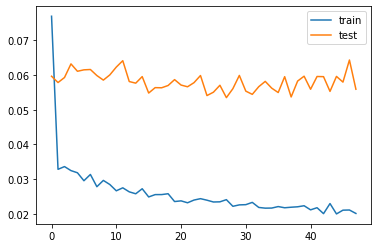

(77, 7)
(77, 7)
(77, 7)
score_train: [15.867] 15.5, 15.5, 15.8, 15.7, 16.3, 15.9, 16.3
(15, 1, 5)
score_test: [27.672] 18.6, 37.4, 42.9, 28.0, 17.4, 17.4, 19.7

RMSE test:  27.67179275111779 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0634
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0361 - val_loss: 0.0637
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0646
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0672
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0632
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0639
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0675
Epoch 8/1000
77/77 [======================

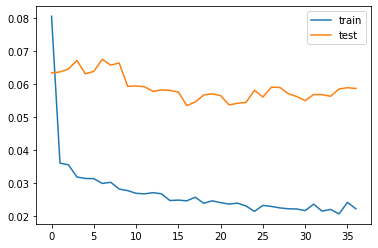

(77, 7)
(77, 7)
(77, 7)
score_train: [15.990] 15.5, 16.1, 16.0, 15.8, 16.5, 15.9, 16.2
(15, 1, 5)
score_test: [28.353] 18.6, 38.3, 42.7, 29.8, 16.1, 20.0, 21.1

RMSE test:  28.353366235241246 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0697
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0695
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0656
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0652
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0672
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0602
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0651
Epoch 8/1000
77/77 [=====================

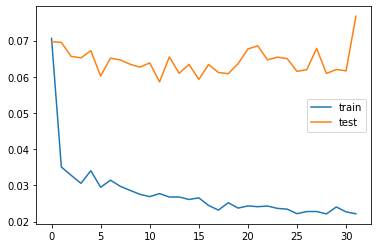

(77, 7)
(77, 7)
(77, 7)
score_train: [17.295] 16.8, 16.6, 17.5, 17.0, 18.2, 16.7, 18.1
(15, 1, 5)
score_test: [32.406] 19.1, 44.4, 46.6, 24.4, 26.3, 24.9, 30.5

RMSE test:  32.40641538203504 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0599
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0578
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0605
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0601
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0604
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0609
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0650
Epoch 8/1000
77/77 [======================

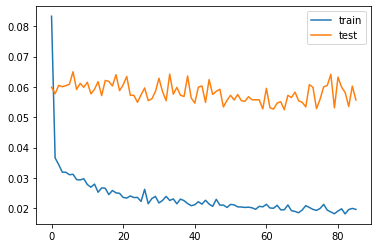

(77, 7)
(77, 7)
(77, 7)
score_train: [15.351] 14.9, 14.9, 15.8, 15.8, 16.0, 14.6, 15.5
(15, 1, 5)
score_test: [27.608] 20.6, 39.1, 41.5, 30.8, 18.1, 12.0, 15.3

RMSE test:  27.608093697822525 

9  	10    	26.7846	0        	26.7846	26.7846

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0624 - val_loss: 0.0699
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0357 - val_loss: 0.0680
Epoch 3/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0672
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0671
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0614
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0601
Epoch 7/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0

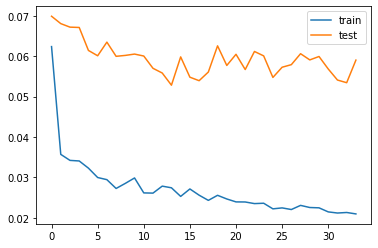

(77, 7)
(77, 7)
(77, 7)
score_train: [16.086] 15.6, 15.9, 16.1, 16.1, 16.6, 15.8, 16.4
(15, 1, 5)
score_test: [28.421] 18.9, 38.4, 44.1, 27.1, 16.9, 19.2, 21.9

RMSE test:  28.420712776497147 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0780 - val_loss: 0.0584
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.0630
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0659
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0623
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0609
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0634
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0646
Epoch 8/1000
77/77 [=====================

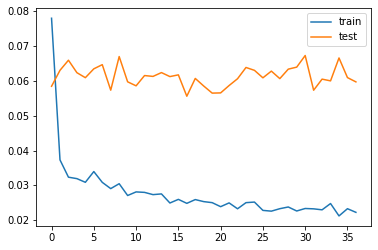

(77, 7)
(77, 7)
(77, 7)
score_train: [16.109] 15.7, 15.8, 16.2, 15.9, 16.5, 16.1, 16.5
(15, 1, 5)
score_test: [28.585] 19.5, 40.2, 44.1, 26.0, 16.1, 18.4, 22.4

RMSE test:  28.58540157169087 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0597
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0597
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0576
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0625
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0629
Epoch 6/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0643
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0626
Epoch 8/1000
77/77 [======================

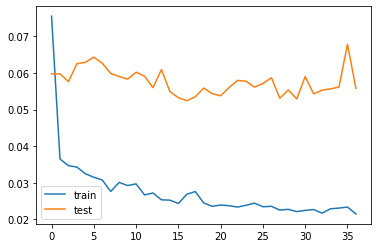

(77, 7)
(77, 7)
(77, 7)
score_train: [16.221] 15.7, 15.9, 16.5, 16.2, 16.8, 16.1, 16.4
(15, 1, 5)
score_test: [27.632] 19.0, 38.6, 44.6, 26.9, 13.6, 15.3, 18.9

RMSE test:  27.63230604530993 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0654 - val_loss: 0.0678
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0672
Epoch 3/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0655
Epoch 4/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0671
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0676
Epoch 6/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0646
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0690
Epoch 8/1000
77/77 [======================

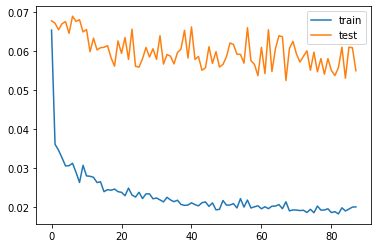

(77, 7)
(77, 7)
(77, 7)
score_train: [15.243] 14.6, 15.0, 15.6, 15.5, 15.5, 14.9, 15.6
(15, 1, 5)
score_test: [27.443] 20.2, 40.4, 38.2, 32.5, 20.7, 11.1, 12.7

RMSE test:  27.443252714764963 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 1s 7ms/step - loss: 0.0727 - val_loss: 0.0652
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0683
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0648
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0650
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0672
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0596
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0613
Epoch 8/1000
77/77 [=====================

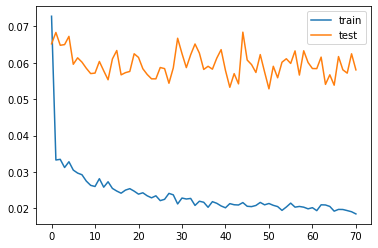

(77, 7)
(77, 7)
(77, 7)
score_train: [15.471] 14.9, 15.6, 15.7, 15.6, 15.9, 15.0, 15.6
(15, 1, 5)
score_test: [28.184] 20.5, 40.5, 41.3, 30.2, 19.7, 13.9, 17.4

RMSE test:  28.183520495416378 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0793 - val_loss: 0.0650
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0670
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0635
Epoch 4/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0658
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0671
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0710
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0643
Epoch 8/1000
77/77 [=====================

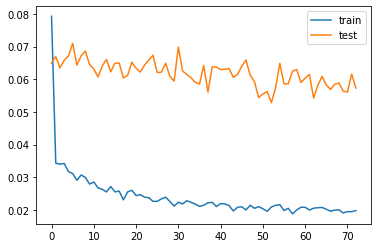

(77, 7)
(77, 7)
(77, 7)
score_train: [15.392] 15.2, 15.3, 15.7, 15.5, 15.9, 14.7, 15.5
(15, 1, 5)
score_test: [28.009] 15.4, 41.3, 41.4, 29.1, 19.1, 15.6, 19.6

RMSE test:  28.00923929998898 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0658 - val_loss: 0.0689
Epoch 2/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0665
Epoch 3/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0699
Epoch 4/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0623
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0641
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0634
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0688
Epoch 8/1000
77/77 [======================

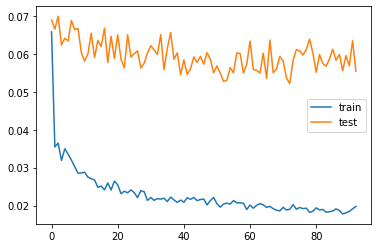

(77, 7)
(77, 7)
(77, 7)
score_train: [14.952] 14.6, 14.5, 15.4, 15.4, 15.4, 14.2, 15.1
(15, 1, 5)
score_test: [27.540] 16.5, 41.9, 41.5, 30.4, 20.0, 8.8, 12.5

RMSE test:  27.53973629736479 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  1
(77, 1, 5)
Epoch 1/1000
77/77 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0560
Epoch 2/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0588
Epoch 3/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0599
Epoch 4/1000
77/77 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0604
Epoch 5/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0599
Epoch 6/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0628
Epoch 7/1000
77/77 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0623
Epoch 8/1000
77/77 [=======================

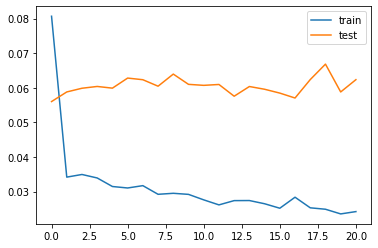

(77, 7)
(77, 7)
(77, 7)
score_train: [16.897] 16.3, 16.4, 16.9, 16.7, 17.4, 16.9, 17.8
(15, 1, 5)
score_test: [29.213] 23.4, 41.3, 45.9, 28.0, 13.2, 15.1, 20.6

RMSE test:  29.213039353261202 

10 	8     	26.7846	0        	26.7846	26.7846


In [76]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =14 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [77]:
print('Best score :', best_score)

Best score : 26.784561315807586


In [78]:
model=model_name
model.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 1, 127)            1397      
_________________________________________________________________
flatten_72 (Flatten)         (None, 127)               0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 127)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 7)                 896       
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________


In [79]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7,14]])
yhat.shape 

(3, 7)

In [80]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [81]:
#yhat

In [82]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7,14]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)
#print(inv_y)

In [83]:
days

DatetimeIndex(['2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
               '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13',
               '2020-06-14'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [84]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:21]
test_res['real']=y_test_true.flatten()[0:21]
test_res.set_index(days,inplace=True)

In [85]:
test_res

,Prediction,real
timestamp,,
2020-05-25,38.022713,27.0
2020-05-26,42.086044,99.0
2020-05-27,35.889286,45.0
2020-05-28,42.034744,24.0
2020-05-29,43.015331,42.0
2020-05-30,46.655128,71.0
2020-05-31,37.039894,66.0
2020-06-01,44.584320,27.0
2020-06-02,57.126106,26.0


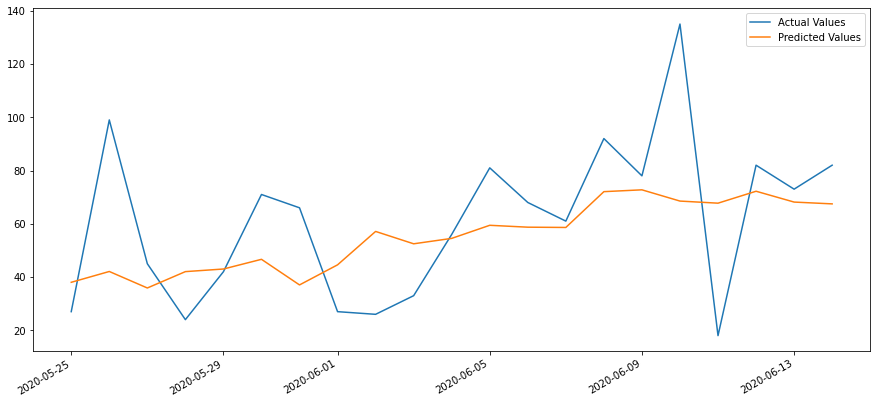

In [86]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [87]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 717.41
RMSE: 26.78
MAE: 20.14
R Squared: 0.16
Max Error: 66.47


In [88]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(77, 7)

In [89]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(77, 7)

In [90]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [91]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [92]:
y_train_pred[0]

array([24.534285, 23.366291, 23.982767, 23.225447, 25.294144, 25.535831,
       28.325886], dtype=float32)

In [93]:
#For plot 
#filter_indices = [0,6,13,20,27,34,41,48,55,62,69,76,83,90,97,104]
filter_indices = [0,6,13,20,27,34,41,48,55,62,69]
y_train_pred = y_train_pred [filter_indices ]

In [94]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [95]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(77, 1, 5)

In [96]:
date_train.head(7)

22928   2020-03-02
22929   2020-03-03
22930   2020-03-04
22931   2020-03-05
22932   2020-03-06
22933   2020-03-07
22934   2020-03-08
Name: date, dtype: datetime64[ns]

In [97]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

83

In [98]:
date_train = date_train.values.flatten()

In [99]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [100]:
Y_train_pred.shape

(77,)

In [101]:
Y_train_real.shape

(77,)

In [102]:
date_train.shape

(84,)

In [103]:
date_train[nb_seq:].shape

(83,)

In [104]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-6

In [105]:
Y_train_real[:-suite_size].shape

(6,)

In [106]:
date_train[nb_seq:].shape

(83,)

In [107]:
Y_train_pred[:-suite_size].shape

(6,)

In [108]:
Y_train_real[:-suite_size].shape

(6,)

In [109]:
date_trainX = date_train[nb_seq:]

In [110]:
date_trainX[0:Y_train_pred.shape[0]].shape

(77,)

In [111]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [112]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [113]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [114]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-03-03,18.416370,24.534285
2020-03-04,20.914591,23.366291
2020-03-05,20.914591,23.982767
2020-03-06,18.416370,23.225447
2020-03-07,20.914591,25.294144
2020-03-08,20.914591,25.535831
2020-03-09,20.914591,28.325886
2020-03-10,20.914591,24.534285
2020-03-11,20.914591,23.366291


In [115]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-05-09,76.291809,83.051872
2020-05-10,85.868317,80.125603
2020-05-11,100.857651,78.974548
2020-05-12,81.704620,85.386177
2020-05-13,108.768677,85.227676
2020-05-14,75.042702,74.772308
2020-05-15,57.138786,69.960060
2020-05-16,57.555161,73.400856
2020-05-17,36.736652,67.041870


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

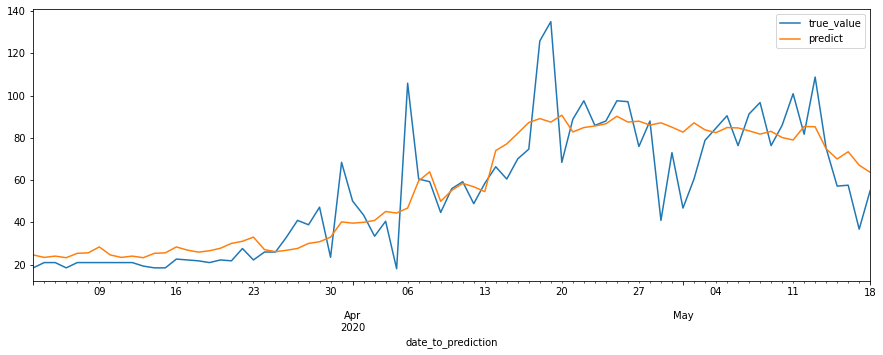

In [116]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [117]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 245.44
RMSE 15.67
MAE 10.96
R2 0.71
maxError 59.11
